In [1]:
# Importing the necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import time
import copy
import pandas as pd
from PIL import Image
from torchvision import datasets, models, transforms

In [2]:
# Defining necessary file paths

model_path = '../Model/Pesticides_Prescription_Model.sav'
labels_path = '../Model/Labels_Pesticides_Prescription_Model.csv'
test_data_dir = '../Dataset/test/'

In [3]:
# Restoring the model

def initialize_alexnet(model_name, num_classes, feature_extract=True, use_pretrained=True):

  model_ft = None
  input_size = 0

  if model_name == "alexnet":
    model_ft = models.alexnet(pretrained=use_pretrained)

    if feature_extract:
        for param in model_ft.parameters():
            param.requires_grad = False
    
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    input_size = 224
  else:
        print("Model name is invalid!")
        exit()

  return model_ft,input_size

model, _ = initialize_alexnet("alexnet", num_classes=15)
model.load_state_dict(torch.load(model_path))
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
# Reading the labels file

labels_df = pd.read_csv(labels_path, header=None, names=['idx','Label'])
labels_dict = dict(zip(labels_df.idx, labels_df.Label))
labels_dict

{0: 'Bell_pepper__Bacterial_spot__Copper_fungicide__Manar_Maneb',
 1: 'Bell_pepper__Healthy__No_chemical_needed__No_pesticides_needed',
 2: 'Potato__Early_blight__Mancozeb__Hayleys_Mancozeb',
 3: 'Potato__Healthy__No_chemical_needed__No_pesticides_needed',
 4: 'Potato__Late_blight__Mancozeb__Hayleys_Mancozeb',
 5: 'Tomato__Bacterial_spot__Copper_fungicide__Manar_Maneb',
 6: 'Tomato__Early_blight__Mancozeb__Hayleys_Mancozeb',
 7: 'Tomato__Healthy__No_chemical_needed__No_pesticides_needed',
 8: 'Tomato__Late_blight__Mancozeb__Hayleys_Mancozeb',
 9: 'Tomato__Leaf_mold__Chlorothalonil__Ronil_Chlorothalonil',
 10: 'Tomato__Mosaic_virus__No_chemical_control__No_pesticides_available',
 11: 'Tomato__Septoria_leaf_spot__Chlorothalonil__Antracol_Propineb',
 12: 'Tomato__Target_spot__Chlorothalonil__Antracol_Propineb',
 13: 'Tomato__Two_spotted_spider_mite__Abamectin__Mig_Abamectin',
 14: 'Tomato__Yellow_leaf_curl_virus__Imidacloprid__Kobra_Imidacloprid'}

In [5]:
# Predicting the output

def predict(img):
    transform = transforms.Compose([            
    transforms.Resize(256),                    
    transforms.CenterCrop(224),                
    transforms.ToTensor(),                     
    transforms.Normalize(                      
    mean=[0.485, 0.456, 0.406],                
    std=[0.229, 0.224, 0.225]                  
    )])

    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)  
    out = model(batch_t)
    _, index = torch.max(out, 1)
    
    return index

def get_label(labels_dict, idx=-1):
    if (idx>=0 and idx<=14):
        label = labels_dict[idx].split("__")
        i = 0
        while (i<4):
            label[i] = ' '.join(map(str, label[i].split("_")))
            i +=1
    else:
        label = ['','','','']
    return label[0],label[1],label[2],label[3]

In [6]:
# Selecting a specific image

def select_img(path):
    img = Image.open(path)
    plt.imshow(img)
    return img

In [7]:
# Selecting a random image

def select_random_img():
    random_folder = np.random.choice(os.listdir(test_data_dir))
    random_image = np.random.choice(os.listdir(test_data_dir + random_folder))
    img = Image.open(test_data_dir + random_folder + '/'  + random_image)
    plt.imshow(img)
    print('Plant : ', ' '.join(map(str, random_folder.split("__")[0].split("_"))))
    print ('Disease : ', ' '.join(map(str, random_folder.split("__")[1].split("_"))))
    return img

In [8]:
# Getting prescription

def get_prescription(img):
    predict_idx = predict(img)
    plant_name, disease_name, chemical_name, pesticide_name = get_label(labels_dict, predict_idx.numpy()[0])
    print('Pesticide prescription for the leaf disease')
    print('*******************************************')
    print('Identified plant : ', plant_name)
    print('Identified disease : ', disease_name)
    print('Prescribing chemical control : ', chemical_name)
    print('Prescribing pesticide name : ', pesticide_name)

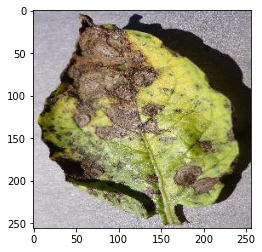

In [9]:
# Select a specific image

image_path = '../Dataset/test/Potato__Early_blight/3ec5894d-dcc2-4276-ba28-0048b6d5605a___RS_Early.B 8027.JPG'
selected_image = select_img(image_path)

Plant :  Tomato
Disease :  Septoria leaf spot


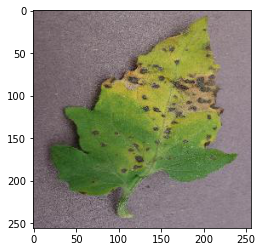

In [10]:
# Select a random image

selected_image = select_random_img()

In [11]:
# Get prescription

get_prescription(selected_image)

Pesticide prescription for the leaf disease
*******************************************
Identified plant :  Tomato
Identified disease :  Septoria leaf spot
Prescribing chemical control :  Chlorothalonil
Prescribing pesticide name :  Antracol Propineb
